# **Aplicaciones Financieras de ML & AI**
## **Examen III:** *AI in Finance*

#### Nombre: Julio César Avila Torreblanca

- **Problema:**
    * Genere un modelo que dato un texto, nos regrese como predicción un salario estimado o un rango salarial estimado (use al menos 3 variables).
        - Use un modelo o variante de Bert.
    * Base de datos: consiste en Empleos, Descripciones de los empleos y Rango salarial.


- **Contenido del notebook**:
    1. Librerías y parámetros
    2. Lectura de datos
    3. EDA
    4. Procesamiento de datos
    5. Modelado
    6. Evaluación

# 1. Librerías y parámetros

In [183]:
# data manipulation
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# nn
from transformers import  AutoTokenizer
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers

# test
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# visualization
import matplotlib.pyplot as plt

# 2. Lectura de datos

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv(
    '/content/drive/MyDrive/Academy/Diplomado_Finanazas&IA/01_Aplicaciones_Financieras_ML&AI/Tests/DataAnalyst.csv',
    #'data/DataAnalyst.csv',
    index_col=0,
    engine='python',
    encoding='utf-8',
)

df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          262 non-null    object 
 1   Salary Estimate    262 non-null    object 
 2   Job Description    262 non-null    object 
 3   Rating             262 non-null    float64
 4   Company Name       262 non-null    object 
 5   Location           262 non-null    object 
 6   Size               262 non-null    object 
 7   Type of ownership  262 non-null    object 
 8   Industry           262 non-null    object 
 9   Sector             262 non-null    object 
 10  Revenue            262 non-null    object 
 11  Competitors        262 non-null    object 
 12  Easy Apply         262 non-null    object 
dtypes: float64(1), object(12)
memory usage: 26.7+ KB


# 3. EDA
Tenemos un dataset con 262 registros sin valores nulos. En esta parte veremos columna a columna que tipo de valores tenemos, para definir las varaibles a considerar al modelo.

Columnas a evaluar:

- `Job Title`
- `Salary Estimate`
- `Job Description`
- `Rating`
- `Company Name`
- `Location`
- `Size`
- `Type of ownership`
- `Industry`
- `Sector`
- `Revenue`
- `Competitors`
- `Easy Apply`


In [8]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,TRUE
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,TRUE


In [9]:
df.describe(include='all')

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
count,262,262,262,262.000000,262,262,262,262,262,262,262,262,262
unique,169,10,262,NaN,217,17,9,12,36,18,14,46,2
top,Data Analyst,$43K-$76K (Glassdoor est.),Job Title :Senior SQL Data Analyst\n\nNo of Op...,NaN,Perficient\n3.6,"New York, NY",1 to 50 employees,Company - Private,-1,Business Services,Unknown / Non-Applicable,-1,-1
freq,65,31,1,NaN,5,214,54,138,47,62,76,207,246
mean,NaN,NaN,NaN,3.103817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.691081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
columns = [
  'Job Title',
  'Salary Estimate',
  'Job Description',
  'Rating',
  'Company Name',
  'Location',
  'Size',
  'Type of ownership',
  'Industry',
  'Sector',
  'Revenue',
  'Competitors',
  'Easy Apply',
]

df[columns].nunique()

,0
Job Title,169
Salary Estimate,10
Job Description,262
Rating,28
Company Name,217
Location,17
Size,9
Type of ownership,12
Industry,36
Sector,18


Para cada variable notemos lo siguiente:
- `Job Title`: título de la vacante, por los tipos de títulos existirán algunos que sean similares. Esto podría ser interesante para medir similitudes entre vacantes. (**Posible variable**)
- `Salary Estimate`: variable a predecir, podrían tomarse los diez intervalos como clases o hacer un procesamiento para obtener un valor continuo a predecir.
- `Job Description`: texto con la descripción del rol. (**Target**)
- `Rating`: valor continuo entre 0-5, en Glassdoor suele ser un rating de la vacante tomada por los usuarios. Este valor puede NO aportar al modelo.
- `Company Name`: nombre de la empresa, no aporta al modelo.
- `Location`: Lugar de la vacante, podría ser importante como variable. Pero debido a que son muy pocas vacantes y queremos generalizar, la descartaremos.
- `Size`: tamaño de la empresa, son pocas las categorías por lo que puede ser una buena variable a incluir en el modelo. (**Posible variable**)
- `Type of ownership`: tipo de empresa, dado que no son muchas categorías podría ser importante para el modelo. (**Posible variable**)
- `Industry`: industria,  dado que son demasiadas categorías lo descartaremos.
- `Sector`: sector al que pertenece, dado que no son muchas categorías podría ser importante para el modelo. (**Posible variable**)
- `Revenue`: intervalo de revenue de la empresa, podria ser importante para conocer las ganancias e impacto de la empresa. (**Posible variable**)
- `Competitors`: número de competidores, no aporta al modelo.
- `Easy Apply`: flag dado por la plataforma para la aplicación, no aporta al modelo.

De esta manera, consideraremos como vriables:
  - `Job Title`: txt a ser tratado con encoder.
  - `Job Description`: txt a ser tratado con encoder.
  - `Size`: txt a ser tratado con encoder.
  - `Type of ownership`: txt a ser tratado con encoder.
  - `Sector`: txt a ser tratado con encoder.
  - `Revenue`: txt a ser tratado con encoder.
  
Y como variable target: `Salary Estimate`.

# 4. Preprocesamiento de los datos
Haremos el siguiente procesamiento:
- Buscaremos predecir el promedio de los salario. Para ello haremos generaremos la target.
- Las variables categóricas, usaremos OHE donde solo consideraremos las categorías con mayor frecuencia.
- Para las variables `Job Title` y `Job Description` tomaremos dos encoders
  - [JobBERT-v2](https://huggingface.co/TechWolf/JobBERT-v2) (sentence-transformersfor job title matching ): toma los títulos de los trabajos para agrupar los más parecidos. Usaremos el encoder para vectorizar el título de los trabajos.
  - [bart-base-job-info-summarizer](https://huggingface.co/TechWolf/JobBERT-v2) (fine-tuned version of facebook/bart-base): toma descripciones de trabajos para resumirlos. Usaremos el encoder para vectorizar las descripciones de los trabajos.
  


## 4.1 Definición de la target

In [11]:
df['Salary Estimate'].unique()

array(['$37K-$66K (Glassdoor est.)', '$46K-$87K (Glassdoor est.)',
       '$51K-$88K (Glassdoor est.)', '$51K-$87K (Glassdoor est.)',
       '$59K-$85K (Glassdoor est.)', '$43K-$76K (Glassdoor est.)',
       '$60K-$110K (Glassdoor est.)', '$41K-$78K (Glassdoor est.)',
       '$45K-$88K (Glassdoor est.)', '$73K-$127K (Glassdoor est.)'],
      dtype=object)

In [42]:
# obtener max y min de los salarios

## intervalo
df.loc[:,['salary_interval']] = df['Salary Estimate'].apply(lambda x: x.split(' ')[0])

## min
df.loc[:,['salary_min']] = df['salary_interval'].apply(lambda x: x.split('-')[0])
df.loc[:,['salary_min']] = df['salary_min'].apply(lambda x: x.replace('$',''))
df.loc[:,['salary_min']] = df['salary_min'].apply(lambda x: x.replace('K',''))
df.loc[:,['salary_min']] = df.loc[:,['salary_min']].astype(int)*1000

## max
df.loc[:,['salary_max']] = df['salary_interval'].apply(lambda x: x.split('-')[1])
df.loc[:,['salary_max']] = df['salary_max'].apply(lambda x: x.replace('$',''))
df.loc[:,['salary_max']] = df['salary_max'].apply(lambda x: x.replace('K',''))
df.loc[:,['salary_max']] = df.loc[:,['salary_max']].astype(int)*1000

## mean
df.loc[:,['salary_mean']] = (df['salary_min'] + df['salary_max'])/2
df['salary_mean'] = df['salary_mean'].astype(float)

In [43]:
df.loc[:,['salary_mean']].describe()

,salary_mean
count,262.000000
mean,67963.740458
std,11262.439786
min,51500.000000
25%,59500.000000
50%,67750.000000
75%,72000.000000
max,100000.000000


In [185]:
lbe = LabelEncoder()
df.loc[:,['lbe_salary_interval']] = lbe.fit_transform(df.loc[:,['salary_interval']])

df.loc[:,['lbe_salary_interval']].value_counts()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,count
lbe_salary_interval,
2,31
0,30
8,30
4,30
5,30
6,30
7,30
1,29
3,11


## 4.3 Data Split

In [201]:
columns = [
  'Job Title',
  'Job Description',
  'Size',
  'Type of ownership',
  'Sector',
  'Revenue',
]

target = ['salary_interval', 'lbe_salary_interval']

X = df.loc[:,columns].copy()
y = df.loc[:,target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)

print(f'X_train size: {X_train.shape}')
print(f'y_train size: {y_train.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_test size: {y_test.shape}')

X_train size: (183, 6)
y_train size: (183, 2)
X_test size: (79, 6)
y_test size: (79, 2)


##  4.4 ETL Orchestration
Buscaremos hacer un ETL que realice:
1. Encodear con OHE las variables categóricas tomando un máximo de categorías (las más frecuentes).
2. Vectorizar el título de los trabajos.
3. Vectorizar la descripción de los trabajos.
4. Unir los vectores y tomar como Input de una Red Neuronal.

Para realizar este ETL seguiremos la estuctura de `pipelines` de sklearn, para ello crearemos nuestros propios transformers customs y uniremos todo.



In [202]:
class EncodeTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms text features using the JobBERT model.

    This transformer uses the JobBERT model to generate embeddings
    (vector representations) of job titles. These embeddings can be
    used as features in machine learning models.

    Attributes:
        jobbert_model_name (str): The name of the JobBERT model to use.
                                  Defaults to 'TechWolf/JobBERT-v2'.
        jobbert_model (SentenceTransformer): The instantiated JobBERT model.
                                           Initialized as None and loaded
                                           during the `fit` method.

    Examples:
        >>> encoder = EncodeTransformer()
        >>> encoder.fit(X_train)
        >>> encoded_titles = encoder.transform(X_test)
    """

    def __init__(self, jobbert_model_name='TechWolf/JobBERT-v2'):
        """
        Initializes the EncodeTransformer.

        Args:
            jobbert_model_name (str): The name of the JobBERT model to use.
        """
        self.jobbert_model_name = jobbert_model_name
        self.jobbert_model = None

    def fit(self, X, y=None):
        """
        Fits the transformer to the training data.

        This method loads the specified JobBERT model.

        Args:
            X (pd.DataFrame): The training data.
                              Must contain a 'Job Title' column.
            y (pd.Series, optional): The labels for the training data.
                                      Not used in this transformer.
                                      Defaults to None.

        Returns:
            self: The fitted EncodeTransformer object.
        """
        self.jobbert_model = SentenceTransformer(self.jobbert_model_name)
        return self

    def transform(self, X):
        """
        Transforms the input data using the JobBERT model.

        Args:
            X (pd.DataFrame): The data to transform.
                              Must contain a 'Job Title' column.

        Returns:
            np.ndarray: The embeddings generated by the JobBERT model.
        """
        X = X['Job Title'].astype(str)  # Ensure job titles are strings
        encoded_titles = self.jobbert_model.encode(X.values)
        return encoded_titles


class TokenizerTransformer(BaseEstimator, TransformerMixin):
    """
    Tokenizes text features using the AutoTokenizer tokenizer.

    This transformer uses the AutoTokenizer tokenizer to convert job
    descriptions into sequences of tokens. These token sequences can
    be used as input to language models.

    Attributes:
        tokenizer_name (str): The name of the tokenizer to use.
                              Defaults to 'avisena/bart-base-job-info-summarizer'.
        tokenizer (AutoTokenizer): The instantiated tokenizer.
                                  Initialized as None and loaded during
                                  the `fit` method.

    Examples:
        >>> tokenizer_transformer = TokenizerTransformer()
        >>> tokenizer_transformer.fit(X_train)
        >>> tokenized_descriptions = tokenizer_transformer.transform(X_test)
    """

    def __init__(self, tokenizer_name="avisena/bart-base-job-info-summarizer"):
        """
        Initializes the TokenizerTransformer.

        Args:
            tokenizer_name (str): The name of the tokenizer to use.
        """
        self.tokenizer_name = tokenizer_name
        self.tokenizer = None

    def fit(self, X, y=None):
        """
        Fits the transformer to the training data.

        This method loads the specified tokenizer.

        Args:
            X (pd.DataFrame): The training data.
                              Must contain a 'Job Description' column.
            y (pd.Series, optional): The labels for the training data.
                                      Not used in this transformer.
                                      Defaults to None.

        Returns:
            self: The fitted TokenizerTransformer object.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)
        return self

    def transform(self, X):
        """
        Tokenizes the input data using the tokenizer.

        Args:
            X (pd.DataFrame): The data to tokenize.
                              Must contain a 'Job Description' column.

        Returns:
            np.ndarray: The token sequences generated by the tokenizer.
        """
        X = X['Job Description'].astype(str)  # Ensure descriptions are strings
        all_encoded_inputs = []
        for job_description in X.values:
            inputs = self.tokenizer.encode(
                job_description,
                return_tensors="pt",
                max_length=1024,
                truncation=True,
                padding='max_length'
            )
            all_encoded_inputs.append(inputs[0].tolist()) # Get the list of token IDs
        return np.array(all_encoded_inputs)  # Return as NumPy array

In [209]:
# columns by tipe
categorical_features = ['Size', 'Type of ownership', 'Sector', 'Revenue']
encode_features = ['Job Title']
tokenizer_features = ['Job Description']

##########################################
############ transformers ################
##########################################
# prepocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False,max_categories=5,
                              handle_unknown='ignore'), categorical_features),
        ('job_titles', EncodeTransformer(), encode_features),
        ('job_descriptions', TokenizerTransformer(), tokenizer_features),
    ])

# etl
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()) # escalamiento de los datos
    ])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=5,
                                                                sparse_output=False),
                                                  ['Size', 'Type of ownership',
                                                   'Sector', 'Revenue']),
                                                 ('job_titles',
                                                  EncodeTransformer(),
                                                  ['Job Title']),
                                                 ('job_descriptions',
                                                  TokenizerTransformer(),
                                                  ['Job Description'])])),
                ('scaler', StandardScaler())])

## 4.5 Procesamiento

In [214]:
 # TRAIN: FIT & TRANSFORM
X_train_transfomed = pipeline.fit_transform(X_train)

# TEST: ONLY TRANSFORM
X_test_transfomed = pipeline.transform(X_test)

In [215]:
print(f'X_train_transformed size: {X_train_transfomed.shape}')
print(f'X_test_transformed size: {X_test_transfomed.shape}')

X_train_transformed size: (183, 1812)
X_test_transformed size: (79, 1812)


# 5. Modelado
Usaremos una red neuronal densa para predecir el salario.

In [217]:
model_nn = keras.models.Sequential([
  layers.Input((X_train_transfomed.shape[1],), name = 'input'),
  layers.Dense(906,  name='first_layer',  activation="linear"),
  #layers.Dense(452,  name='second_layer', activation="relu", kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(226,  name='third_layer',  activation="linear"),
  #layers.Dense(112,  name='fourth_layer', activation="relu", kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(56,  name='fifth_layer', activation="relu"),
  #layers.Dense(28,  name='sixth_layer', activation="linear", kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(10, name='output', activation='softmax')
  ]
)

model_nn.compile(
    loss='sparse_categorical_crossentropy', #log_loss
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)


model_nn.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_layer (Dense)             │ (None, 906)            │     1,642,578 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ third_layer (Dense)             │ (None, 226)            │       204,982 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fifth_layer (Dense)             │ (None, 56)             │        12,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,860,842 (7.10 MB)

 Trainable params: 1,860,842 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [218]:
# train
history = model_nn.fit(
    X_train_transfomed,
    y_train['lbe_salary_interval'].values,
    epochs=75,
    batch_size = 3,
    shuffle = True,
    validation_split=.3,
)

Epoch 1/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.0910 - loss: 6.1494 - val_accuracy: 0.1818 - val_loss: 11.1631
Epoch 2/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5962 - loss: 2.3481 - val_accuracy: 0.1455 - val_loss: 12.2533
Epoch 3/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8858 - loss: 0.7124 - val_accuracy: 0.1455 - val_loss: 14.7090
Epoch 4/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8667 - loss: 0.5139 - val_accuracy: 0.2182 - val_loss: 15.4134
Epoch 5/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8801 - loss: 0.7158 - val_accuracy: 0.1818 - val_loss: 15.7425
Epoch 6/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9166 - loss: 0.3557 - val_accuracy: 0.1636 - val_loss: 17.2854
Epoch 7/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9864 - loss: 0.3648 - val_accuracy: 0.1455 - val_loss: 17.3243
Epoch 8/75
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9828 - loss: 0.2181 - val_accuracy: 0.1

# 6. Evaluación

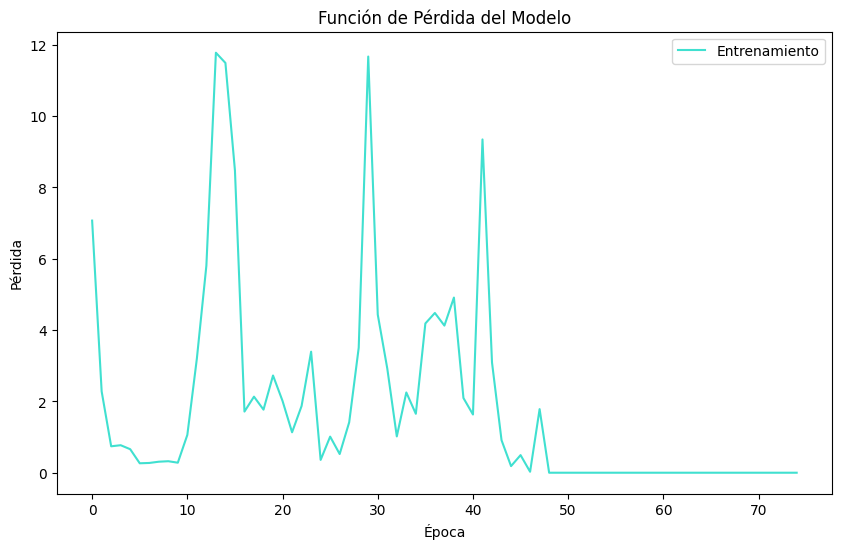

In [219]:
# Graficar la función de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento', color='turquoise')
plt.title('Función de Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [220]:
y_train_pred = model_nn.predict(X_train_transfomed)
y_test_pred = model_nn.predict(X_test_transfomed)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [221]:
from sklearn.metrics import classification_report

# ... (código anterior) ...

# Train predictions
y_train_pred = model_nn.predict(X_train_transfomed)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)  # Get predicted labels

# Test predictions
y_test_pred = model_nn.predict(X_test_transfomed)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)  # Get predicted labels


print('Train Classification Report:')
print(classification_report(y_train['lbe_salary_interval'], y_train_pred_labels))

print('-'*60)

print('Test Classification Report:')
print(classification_report(y_test['lbe_salary_interval'], y_test_pred_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        21
           1       0.85      0.58      0.69        19
           2       0.90      0.83      0.86        23
           3       0.70      0.88      0.78         8
           4       0.78      0.75      0.77        24
           5       0.58      0.74      0.65        19
           6       0.82      0.78      0.80        18
           7       0.94      0.77      0.85        22
           8       0.74      0.70      0.72        20
           9       0.54      0.78      0.64         9

    accuracy                           0.76       183
   macro avg       0.76      0.77      0.75       183
weighted avg       0.78      0.76      0.76       183

------------------------------------------------------------
Test Classification Report:
              precision    recall  f1-score   s

Exception ignored in: <function _xla_gc_callback at 0x7efd9d15ef20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


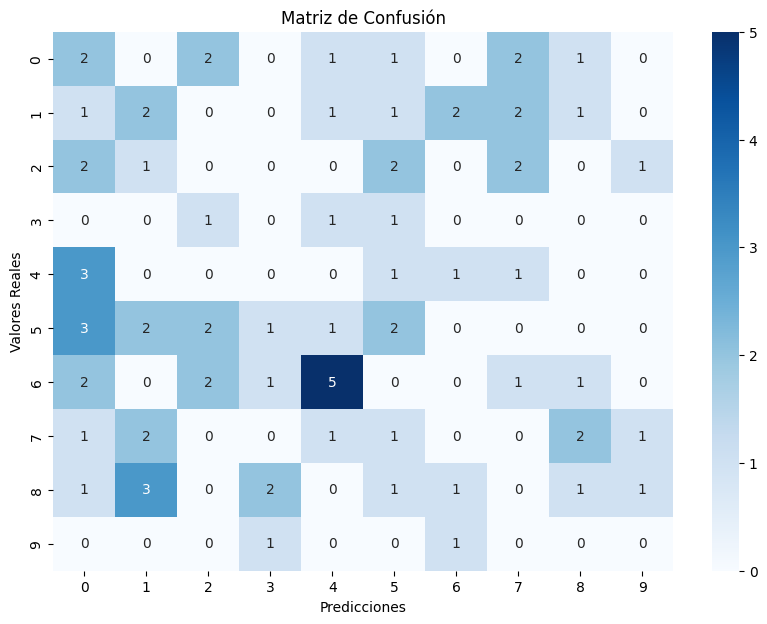

In [200]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (código anterior para obtener y_test_pred_labels) ...

# Calcular la matriz de confusión
cm = confusion_matrix(y_test['lbe_salary_interval'], y_test_pred_labels)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()